# Comparing Various Ordinal Embedding Algorithms

In [1]:
import time
import FORTE.utils as utils
from FORTE.algorithms import NuclearNormProjected, FactoredGradient
import blackbox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import altair

First, to demonstrate the basic idea of embedding from triplet data, we generate a true centered set of points `Xtrue` in two dimensions and using just ordinal information about `Xtruue`, find a set of points satisfying the same ordinal constraints.

A triplet is a three tuple (i,j,k) which represents that X_i is closer to X_j than X_k. We add 10*nd*log(n) such triplets to the training set, `Strain`, and the same number to a test set `Stest`. 

In [2]:
n = 100
d = 2
num_triplets = 20*d*n*np.log(n)

Xtrue = np.random.randn(n, d)
Xtrue = Xtrue - 1. / n * np.dot(np.ones((n, n)),  Xtrue)
Mtrue = np.dot(Xtrue, Xtrue.transpose())
trace_norm = np.trace(Mtrue)

# Train and test set
Strain = utils.triplets(Xtrue, num_triplets)
Stest = utils.triplets(Xtrue, num_triplets)

We now use the `FactoredGradient`  algorithm to find an embedding `Xhat` that agrees with these triplets. A Procrustes transformation is used to align `Xhat` with `Xtrue`. This may take a few seconds to run.

In [3]:
Xhat = FactoredGradient.computeEmbedding(n, d, Strain,
                                         num_random_restarts=0,
                                         max_num_passes_SGD=16, max_iter_GD=50,
                                         max_norm=1, epsilon=0.01, verbose=False)
print ('Empirical Training loss = {},' 
       'Empirical Test loss = {}').format(utils.empirical_lossX(Xhat, Strain),
                                          utils.empirical_lossX(Xhat, Stest))
                                       

Empirical Training loss = 0.0318675352877,Empirical Test loss = 0.0377307274701


In [4]:
Mhat =  NuclearNormProjected.computeEmbedding(n, d,
                                                 Strain,
                                                 max_iter_GD=10000,
                                                 epsilon=0.000001,
                                                 trace_norm=trace_norm,
                                                 verbose=False)

print ('Empirical Training loss = {},' 
       'Empirical Test loss = {}').format(utils.empirical_lossM(Mhat, Strain),
                                          utils.empirical_lossM(Mhat, Stest))

Empirical Training loss = 0.0152008686211,Empirical Test loss = 0.0327904451683


Finally we use a Procrustes transformation to align `Xtrue` with `Xhat` and plot the resulting embeddings.

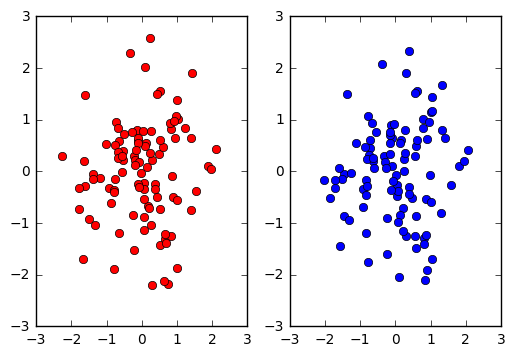

In [5]:
_, Xpro, _ = utils.procrustes(Xtrue, Xhat)
plt.figure(1)
plt.subplot(121); plt.plot(*zip(*Xtrue), marker='o', color='r', ls='')
plt.subplot(122); plt.plot(*zip(*Xpro), marker='o', color='b', ls='')
plt.show()


Now that we see how basic embedding works, we will compare the various embedding algorithms in the `FORTE` package to understand 

- Their accuracy at embedding.
- Their average run-time. 
-  

# Speed Comparisons

In [6]:
blackbox.set_experiment('SpeedTest')

In [7]:
# run a test
blackbox.takeoff('Factored Gradient', force=True)
t_FG = time.time()
Xhat_FG = FactoredGradient.computeEmbedding(n, d, Strain,
                                         num_random_restarts=0,
                                         max_num_passes_SGD=16, max_iter_GD=50,
                                         max_norm=1, epsilon=0.01, verbose=False)
blackbox.land()
blackbox.takeoff('Nuclear Norm PGD', force=True)
t_PGD = time.time()
Mhat =  NuclearNormProjected.computeEmbedding(n, d,
                                                 Strain,
                                                 max_iter_GD=10000,
                                                 epsilon=0.000001,
                                                 trace_norm=trace_norm,
                                                 verbose=False)
blackbox.land()


## Get the data from blackbox

In [12]:
exp = blackbox.get_experiment('SpeedTest')
print exp.list_runs()

runs = []
for key in exp.list_runs():
    run = exp.get_run(key).events
    start_time = t_PGD if key == 'Nuclear Norm PGD' else t_FG
    _ = [r.update({'experiment': key, 'start time': start_time}) for r in run]
    runs += run
    
df = pd.DataFrame(runs)
df['elapsed time'] = df['timestamp'] - df['start time']

[u'Factored Gradient', u'Nuclear Norm PGD']


In [13]:
df.head()

,Delta,G_norm,alpha,duration,emp_loss,epoch,experiment,function_call,inner_t,input,iter,log_loss,rel_max_grad,result,start time,time_called,time_ended,timestamp,elapsed time
0,NaN,0.020877,0.5000,NaN,0.492671,0.0,Factored Gradient,NaN,NaN,NaN,18420.0,1.055426,0.025875,NaN,1.479330e+09,NaN,NaN,1.479330e+09,1.083279
1,NaN,0.011859,0.2500,NaN,0.460315,0.0,Factored Gradient,NaN,NaN,NaN,55260.0,0.870007,0.026701,NaN,1.479330e+09,NaN,NaN,1.479330e+09,2.775383
2,NaN,0.005465,0.1250,NaN,0.250977,0.0,Factored Gradient,NaN,NaN,NaN,128940.0,0.509995,0.022019,NaN,1.479330e+09,NaN,NaN,1.479330e+09,5.633703
3,NaN,0.003736,0.0625,NaN,0.184962,0.0,Factored Gradient,NaN,NaN,NaN,276300.0,0.438397,0.017288,NaN,1.479330e+09,NaN,NaN,1.479330e+09,11.068001
4,NaN,0.003268,22.0000,NaN,0.121336,NaN,Factored Gradient,NaN,0.0,NaN,1.0,0.380159,0.017620,NaN,1.479330e+09,NaN,NaN,1.479330e+09,12.155145


In [14]:
for key in exp.list_runs():
    run = exp.get_run(key).events
    print len(run)

8
44


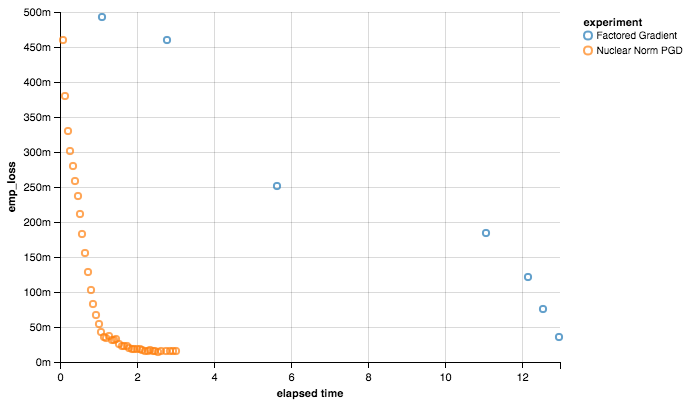

In [15]:
from altair import Chart
Chart(df).mark_point().encode(
    x='elapsed time', y='emp_loss', color='experiment')